# Smile Detection using Convolutional Neural Networks

In [1]:
# Inspired work from Kyle McDonald
# Project: https://github.com/kylemcdonald/SmileCNN

In [8]:
#Download dataset
!wget https://github.com/hromi/SMILEsmileD/archive/master.zip
!unzip -q master.zip
!rm master.zip

--2016-06-14 12:47:16--  https://github.com/hromi/SMILEsmileD/archive/master.zip
Resolent github.com (github.com)... 192.30.252.129
S'està connectant a github.com (github.com)|192.30.252.129|:443... conectat.
HTTP: Petició enviada, esperant resposta... 302 Found
Localització: https://codeload.github.com/hromi/SMILEsmileD/zip/master [el següent]
--2016-06-14 12:47:16--  https://codeload.github.com/hromi/SMILEsmileD/zip/master
Resolent codeload.github.com (codeload.github.com)... 192.30.253.121
S'està connectant a codeload.github.com (codeload.github.com)|192.30.253.121|:443... conectat.
HTTP: Petició enviada, esperant resposta... 200 OK
Longitud: 41620712 (40M) [application/zip]
S'està desant a: «master.zip»

100%[======================================>] 41.620.712  5,06MB/s   en 16s    

2016-06-14 12:47:33 (2,45 MB/s) - s'ha desat «master.zip» [41620712/41620712]



In [9]:
#util and imports
import os
import fnmatch
from cStringIO import StringIO
import numpy as np
import PIL.Image
import IPython.display
import shutil


def list_all_files(directory, extensions=None):
    for root, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            base, ext = os.path.splitext(filename)
            joined = os.path.join(root, filename)
            if extensions is None or ext.lower() in extensions:
                yield joined


def show_array(a, fmt='png', filename=None):
    a = np.uint8(np.clip(a, 0, 255))
    image_data = StringIO()
    PIL.Image.fromarray(a).save(image_data, fmt)
    if filename is None:
        IPython.display.display(IPython.display.Image(data=image_data.getvalue()))
    else:
        with open(filename, 'w') as f:
            image_data.seek(0)
            shutil.copyfileobj(image_data, f)

def find_rectangle(n, max_ratio=2):
    sides = []
    square = int(math.sqrt(n))
    for w in range(square, max_ratio * square):
        h = n / w
        used = w * h
        leftover = n - used
        sides.append((leftover, (w, h)))
    return sorted(sides)[0][1]

# should work for 1d and 2d images, assumes images are square but can be overriden
def make_mosaic(images, n=None, nx=None, ny=None, w=None, h=None):
    if n is None and nx is None and ny is None:
        nx, ny = find_rectangle(len(images))
    else:
        nx = n if nx is None else nx
        ny = n if ny is None else ny
    images = np.array(images)
    if images.ndim == 2:
        side = int(np.sqrt(len(images[0])))
        h = side if h is None else h
        w = side if w is None else w
        images = images.reshape(-1, h, w)
    else:
        h = images.shape[1]
        w = images.shape[2]
    image_gen = iter(images)
    mosaic = np.empty((h*ny, w*nx))
    for i in range(ny):
        ia = (i)*h
        ib = (i+1)*h
        for j in range(nx):
            ja = j*w
            jb = (j+1)*w
            mosaic[ia:ib, ja:jb] = next(image_gen)
    return mosaic

In [10]:
negative_paths = list(list_all_files('SMILEsmileD-master/SMILEs/negatives/negatives7/', ['.jpg']))
print 'loaded', len(negative_paths), 'negative examples'
positive_paths = list(list_all_files('SMILEsmileD-master/SMILEs/positives/positives7/', ['.jpg']))
print 'loaded', len(positive_paths), 'positive examples'
examples = [(path, 0) for path in negative_paths] + [(path, 1) for path in positive_paths]

loaded 9475 negative examples
loaded 3690 positive examples


In [11]:
import numpy as np
from skimage.measure import block_reduce
from skimage.io import imread

def examples_to_dataset(examples, block_size=2):
    X = []
    y = []
    for path, label in examples:
        img = imread(path, as_grey=True)
        img = block_reduce(img, block_size=(block_size, block_size), func=np.mean)
        img = img.reshape((32*32))
        X.append(img)
        if(label==0):
            y.append((1,0))
        else:
            y.append((0,1))
    return np.asarray(X), np.asarray(y)

X, Y = examples_to_dataset(examples)
X = np.asarray(X,dtype=np.float32)/ 255.
Y = np.asarray(Y,dtype=np.int32)
print X.dtype, X.min(), X.max(), X.shape

float32 0.0 1.0 (13165, 1024)


In [12]:
# Split data into train and test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=2)

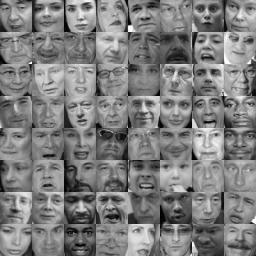

In [13]:
#show Negative images
show_array(255 * make_mosaic(X[:len(negative_paths)], 8), fmt='jpeg') # negative at the beginning

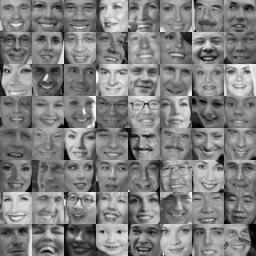

In [14]:
#show Positive images
show_array(255 * make_mosaic(X[-len(positive_paths):], 8), fmt='jpeg') # positive at the end

In [15]:
import tensorflow as tf

In [16]:
# Network Parameters
n_input = X.shape[1]
n_classes = 2 # (Smile vs. No Smile)
dropout = 0.75 # Dropout, probability to keep units

In [17]:
# Parameters
learning_rate = 0.001
training_iters = 8820
batch_size = 128
display_step = 10
training_epochs=200

In [18]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [19]:
# Create model
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], 
                                                  padding='SAME'),b))

def max_pool(img, k):
    return tf.nn.max_pool(img, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def conv_net(_X, _weights, _biases, _dropout):
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 32, 32, 1])

    # Convolution Layer
    conv1 = conv2d(_X, _weights['wc1'], _biases['bc1'])
    
    # Convolution Layer
    conv2 = conv2d(conv1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2, k=2)
    # Apply Dropout
    conv2 = tf.nn.dropout(conv2, _dropout)

    # Fully connected layer
    # Reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv2, [-1, _weights['wd1'].get_shape().as_list()[0]]) 
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, _weights['wd1']), _biases['bd1']))
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, _weights['out']), _biases['out'])
    return out

In [20]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 9],stddev=0.01)), 
    # 5x5 conv, 32 inputs, 32 outputs
    'wc2': tf.Variable(tf.truncated_normal([3, 3, 9, 9],stddev=0.01)), 
    # fully connected, 16*16*32 inputs, 1024 outputs
    'wd1': tf.Variable(tf.truncated_normal([16*16*9, 16],stddev=0.01)), 
    # 128 inputs, 2 outputs (class prediction)
    'out': tf.Variable(tf.truncated_normal([16, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([9])),
    'bc2': tf.Variable(tf.random_normal([9])),
    'bd1': tf.Variable(tf.random_normal([16])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [21]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

In [22]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(pred, y,pos_weight=10))
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [23]:
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [24]:
# Initializing the variables
init = tf.initialize_all_variables()

Epoch 0, Minibatch Loss= 1.513630, Training Accuracy= 0.71094


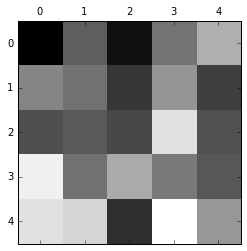

Epoch 1, Minibatch Loss= 1.559660, Training Accuracy= 0.71094
Epoch 2, Minibatch Loss= 1.483717, Training Accuracy= 0.71094
Epoch 3, Minibatch Loss= 1.478282, Training Accuracy= 0.71094
Epoch 4, Minibatch Loss= 1.406869, Training Accuracy= 0.71094
Epoch 5, Minibatch Loss= 1.324301, Training Accuracy= 0.77344
Epoch 6, Minibatch Loss= 1.254013, Training Accuracy= 0.79688
Epoch 7, Minibatch Loss= 1.215106, Training Accuracy= 0.81250
Epoch 8, Minibatch Loss= 1.148481, Training Accuracy= 0.81250
Epoch 9, Minibatch Loss= 1.164232, Training Accuracy= 0.82031
Epoch 10, Minibatch Loss= 1.103023, Training Accuracy= 0.82812
Epoch 11, Minibatch Loss= 1.093677, Training Accuracy= 0.82812
Epoch 12, Minibatch Loss= 1.070979, Training Accuracy= 0.82031
Epoch 13, Minibatch Loss= 1.045373, Training Accuracy= 0.84375
Epoch 14, Minibatch Loss= 1.064869, Training Accuracy= 0.82812
Epoch 15, Minibatch Loss= 1.038268, Training Accuracy= 0.84375
Epoch 16, Minibatch Loss= 1.017904, Training Accuracy= 0.84375
E

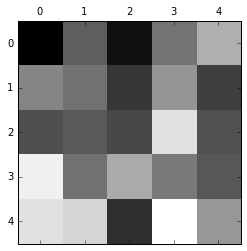

Epoch 51, Minibatch Loss= 0.907561, Training Accuracy= 0.86719
Epoch 52, Minibatch Loss= 0.913714, Training Accuracy= 0.86719
Epoch 53, Minibatch Loss= 0.895266, Training Accuracy= 0.86719
Epoch 54, Minibatch Loss= 0.894722, Training Accuracy= 0.87500
Epoch 55, Minibatch Loss= 0.879385, Training Accuracy= 0.86719
Epoch 56, Minibatch Loss= 0.893341, Training Accuracy= 0.87500
Epoch 57, Minibatch Loss= 0.870475, Training Accuracy= 0.87500
Epoch 58, Minibatch Loss= 0.887642, Training Accuracy= 0.87500
Epoch 59, Minibatch Loss= 0.865484, Training Accuracy= 0.87500
Epoch 60, Minibatch Loss= 0.877098, Training Accuracy= 0.88281
Epoch 61, Minibatch Loss= 0.850586, Training Accuracy= 0.87500
Epoch 62, Minibatch Loss= 0.842274, Training Accuracy= 0.88281
Epoch 63, Minibatch Loss= 0.840926, Training Accuracy= 0.86719
Epoch 64, Minibatch Loss= 0.833015, Training Accuracy= 0.87500
Epoch 65, Minibatch Loss= 0.851462, Training Accuracy= 0.85938
Epoch 66, Minibatch Loss= 0.806686, Training Accuracy= 

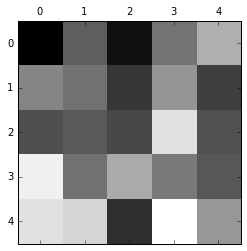

Epoch 101, Minibatch Loss= 0.715137, Training Accuracy= 0.89062
Epoch 102, Minibatch Loss= 0.692035, Training Accuracy= 0.89062
Epoch 103, Minibatch Loss= 0.668129, Training Accuracy= 0.89844
Epoch 104, Minibatch Loss= 0.640137, Training Accuracy= 0.90625
Epoch 105, Minibatch Loss= 0.659148, Training Accuracy= 0.86719
Epoch 106, Minibatch Loss= 0.644499, Training Accuracy= 0.89844
Epoch 107, Minibatch Loss= 0.668547, Training Accuracy= 0.88281
Epoch 108, Minibatch Loss= 0.652818, Training Accuracy= 0.89062
Epoch 109, Minibatch Loss= 0.643170, Training Accuracy= 0.89062
Epoch 110, Minibatch Loss= 0.651622, Training Accuracy= 0.89844
Epoch 111, Minibatch Loss= 0.634752, Training Accuracy= 0.88281
Epoch 112, Minibatch Loss= 0.630420, Training Accuracy= 0.89844
Epoch 113, Minibatch Loss= 0.668513, Training Accuracy= 0.88281
Epoch 114, Minibatch Loss= 0.654196, Training Accuracy= 0.90625
Epoch 115, Minibatch Loss= 0.659743, Training Accuracy= 0.89062
Epoch 116, Minibatch Loss= 0.645165, Tra

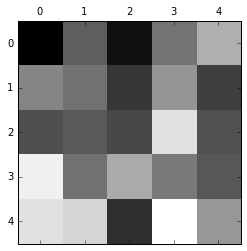

Epoch 151, Minibatch Loss= 0.538965, Training Accuracy= 0.91406
Epoch 152, Minibatch Loss= 0.557346, Training Accuracy= 0.90625
Epoch 153, Minibatch Loss= 0.560946, Training Accuracy= 0.91406
Epoch 154, Minibatch Loss= 0.550614, Training Accuracy= 0.92969
Epoch 155, Minibatch Loss= 0.555634, Training Accuracy= 0.92188
Epoch 156, Minibatch Loss= 0.588275, Training Accuracy= 0.92188
Epoch 157, Minibatch Loss= 0.543597, Training Accuracy= 0.92969
Epoch 158, Minibatch Loss= 0.546793, Training Accuracy= 0.92188
Epoch 159, Minibatch Loss= 0.549577, Training Accuracy= 0.92969
Epoch 160, Minibatch Loss= 0.545699, Training Accuracy= 0.91406
Epoch 161, Minibatch Loss= 0.544243, Training Accuracy= 0.92969
Epoch 162, Minibatch Loss= 0.546162, Training Accuracy= 0.91406
Epoch 163, Minibatch Loss= 0.542206, Training Accuracy= 0.91406
Epoch 164, Minibatch Loss= 0.527874, Training Accuracy= 0.90625
Epoch 165, Minibatch Loss= 0.533248, Training Accuracy= 0.92969
Epoch 166, Minibatch Loss= 0.565103, Tra

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
X_train = X_train.reshape(X_train.shape[0],1024)

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
  
    for epoch in range(training_epochs):
        step = 1
        # Keep training until reach max iterations
        while step * batch_size < training_iters:
            batch_xs, batch_ys = X_train[(batch_size*(step-1)):batch_size*(step)],y_train[(batch_size*(step-1)):batch_size*(step)]
            # Fit training using batch data
            sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
            step += 1
        # Calculate batch accuracy
        if(epoch%1 == 0):
            # Calculate batch loss
            acc,conv1filter = sess.run([accuracy,weights['wc1']], feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            print "Epoch " + str(epoch) + ", Minibatch Loss= " + \
                          "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc)
        if(epoch%50 == 0):
            #acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            plt.figure()
            #plt.matshow(make_mosaic(conv1filter.reshape(9,32).T, 4),cmap="gray")
            plt.matshow(conv1filter[:,:,0,1],cmap="gray")
            plt.show()
            
            
    print "Optimization Finished!"
    # Calculate accuracy for 256 mnist test images
    print "Testing Accuracy:", sess.run(accuracy, feed_dict={x: X_test, 
                                                                 y: y_test, 
                                                                 keep_prob: 1.})

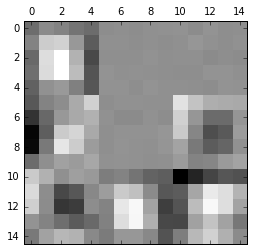

In [26]:
plt.figure()
plt.matshow(make_mosaic(conv1filter.reshape(25,9).T, 3),cmap="gray")
plt.show()